In [1]:
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm
import itertools as it

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

#important import 
import pandas as pd
import numpy as np
import os
import wrangle as w

In [2]:
# plotting defaults
plt.rc('figure', figsize=(16, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [3]:
#Acquire superstore data from codeup database
df = w.get_superstore_data()

In [4]:
df.head()

,Region ID,Category ID,Product ID,Customer ID,Order ID,Order Date,Ship Date,Ship Mode,Segment,Country,...,Postal Code,Sales,Quantity,Discount,Profit,Customer Name,Product Name,Category,Sub-Category,Region Name
0,1,1,FUR-BO-10001798,CG-12520,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,United States,...,42420.0,261.9600,2.0,0.00,41.9136,Claire Gute,Bush Somerset Collection Bookcase,Furniture,Bookcases,South
1,1,2,FUR-CH-10000454,CG-12520,CA-2016-152156,2016-11-08,2016-11-11,Second Class,Consumer,United States,...,42420.0,731.9400,3.0,0.00,219.5820,Claire Gute,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs,South
2,1,4,FUR-TA-10000577,SO-20335,US-2015-108966,2015-10-11,2015-10-18,Standard Class,Consumer,United States,...,33311.0,957.5775,5.0,0.45,-383.0310,Sean O'Donnell,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables,South
3,1,5,OFF-ST-10000760,SO-20335,US-2015-108966,2015-10-11,2015-10-18,Standard Class,Consumer,United States,...,33311.0,22.3680,2.0,0.20,2.5164,Sean O'Donnell,Eldon Fold 'N Roll Cart System,Office Supplies,Storage,South
4,1,11,OFF-PA-10002365,AA-10480,CA-2017-114412,2017-04-15,2017-04-20,Standard Class,Consumer,United States,...,28027.0,15.5520,3.0,0.20,5.4432,Andrew Allen,Xerox 1967,Office Supplies,Paper,South


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 0 to 1733
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region ID      1734 non-null   int64  
 1   Category ID    1734 non-null   int64  
 2   Product ID     1734 non-null   object 
 3   Customer ID    1734 non-null   object 
 4   Order ID       1734 non-null   object 
 5   Order Date     1734 non-null   object 
 6   Ship Date      1734 non-null   object 
 7   Ship Mode      1734 non-null   object 
 8   Segment        1734 non-null   object 
 9   Country        1734 non-null   object 
 10  City           1734 non-null   object 
 11  State          1734 non-null   object 
 12  Postal Code    1734 non-null   float64
 13  Sales          1734 non-null   float64
 14  Quantity       1734 non-null   float64
 15  Discount       1734 non-null   float64
 16  Profit         1734 non-null   float64
 17  Customer Name  1734 non-null   object 
 18  Product 

In [6]:
#Checking the nulls
df.isnull().sum().sum()

0

In [7]:
#Cleaning superstore data
df = w.prep_superstore(df, 'Order Date', 'Ship Date')

In [8]:
#Check to see if function rename the columns correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1734 entries, 2014-01-04 to 2017-12-30
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   product_id     1734 non-null   object        
 1   customer_id    1734 non-null   object        
 2   order_id       1734 non-null   object        
 3   ship_date      1734 non-null   datetime64[ns]
 4   ship_mode      1734 non-null   object        
 5   segment        1734 non-null   object        
 6   country        1734 non-null   object        
 7   city           1734 non-null   object        
 8   state          1734 non-null   object        
 9   postal_code    1734 non-null   float64       
 10  sales          1734 non-null   float64       
 11  quantity       1734 non-null   float64       
 12  discount       1734 non-null   float64       
 13  profit         1734 non-null   float64       
 14  customer_name  1734 non-null   object        
 15  pro

In [9]:
#Let's take a look about the statistics of numeric values in the data.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
postal_code,1734.0,53501.926182,32180.245224,1841.0000,19143.0000,50315.00000,85705.00000,98661.000
sales,1734.0,229.206358,532.862614,1.0800,16.6950,52.24500,209.91750,8159.952
quantity,1734.0,3.794694,2.297407,1.0000,2.0000,3.00000,5.00000,14.000
discount,1734.0,0.160110,0.206419,0.0000,0.0000,0.20000,0.20000,0.800
profit,1734.0,21.880351,202.891949,-3839.9904,1.7024,8.07305,27.41445,3177.475
year,1734.0,2015.679931,1.086921,2014.0000,2015.0000,2016.00000,2017.00000,2017.000


In [10]:
#Let's see how many categories of products we have in the data.
df.category.unique()

array(['Office Supplies', 'Technology', 'Furniture'], dtype=object)

In [11]:
df.category.value_counts()

Office Supplies    1055
Furniture           360
Technology          319
Name: category, dtype: int64

In [12]:
# Extract the data of Office Supplies
office_supplies = df.loc[df['category'] == 'Office Supplies']

In [13]:
#Get 4-year office supplies sales data.
office_supplies.index.min(), office_supplies.index.max()

(Timestamp('2014-01-04 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [14]:
office_supplies = office_supplies.sort_values('Order Date')
office_supplies = office_supplies.groupby('Order Date')['sales'].sum().reset_index()
office_supplies.head()

,Order Date,sales
0,2014-01-04,288.060
1,2014-01-09,9.344
2,2014-01-10,2.890
3,2014-01-13,640.520
4,2014-01-16,48.660


In [15]:
office_supplies = office_supplies.set_index('Order Date')
office_supplies.head()

,sales
Order Date,
2014-01-04,288.060
2014-01-09,9.344
2014-01-10,2.890
2014-01-13,640.520
2014-01-16,48.660


In [16]:
#using the start of each month as the timestamp
monthly = office_supplies['sales'].resample('MS').mean()

In [17]:
monthly

Order Date
2014-01-01     173.734000
2014-02-01      58.909500
2014-03-01     163.820286
2014-04-01      99.149250
2014-05-01     483.108000
2014-06-01     357.797111
2014-07-01     172.297667
2014-08-01     281.512444
2014-09-01     144.181143
2014-10-01     121.782500
2014-11-01     310.994889
2014-12-01     166.427077
2015-01-01      27.968000
2015-02-01       5.280000
2015-03-01    1035.816750
2015-04-01     190.845778
2015-05-01     442.653333
2015-06-01      62.553000
2015-07-01     124.763625
2015-08-01     458.844000
2015-09-01     316.783364
2015-10-01     103.108727
2015-11-01     211.088200
2015-12-01     268.964429
2016-01-01      25.830000
2016-02-01     367.092000
2016-03-01     130.030100
2016-04-01     270.821929
2016-05-01     207.683200
2016-06-01     394.874800
2016-07-01     212.724444
2016-08-01     165.482250
2016-09-01     415.461778
2016-10-01     284.847875
2016-11-01     155.968643
2016-12-01     355.051375
2017-01-01     425.522400
2017-02-01     185.209250
2

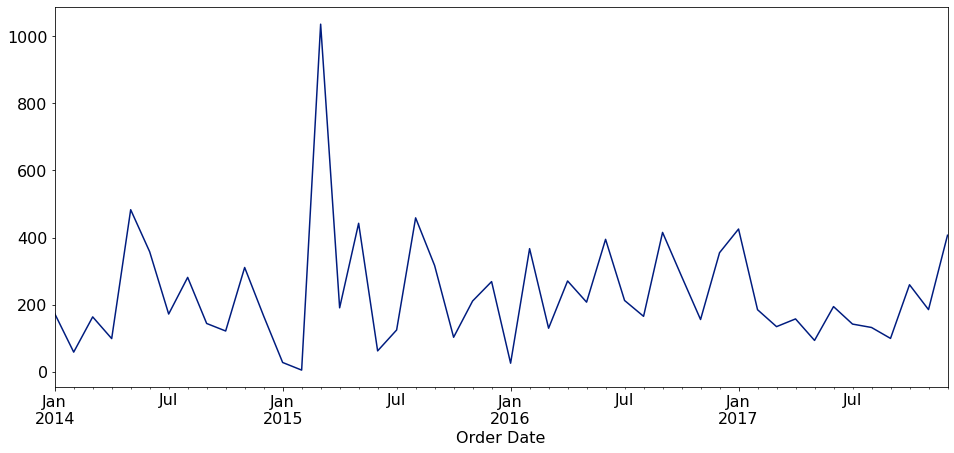

In [18]:
#Lets see monthly sales
monthly.plot()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always high at the beginning of the year and low at the end of the year.

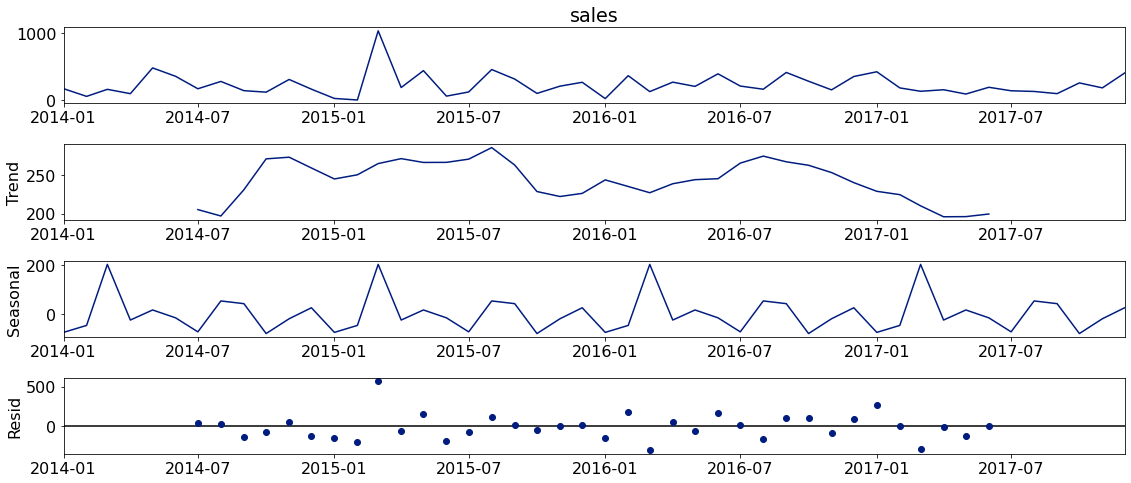

In [19]:
# Using decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.
sm.tsa.seasonal_decompose(monthly).plot()
None

The figure above clearly shows the seasonality in our data, and the trend is gradually increasing through the years.

In [20]:
train, validate, test = w.split_time_series_data(office_supplies)

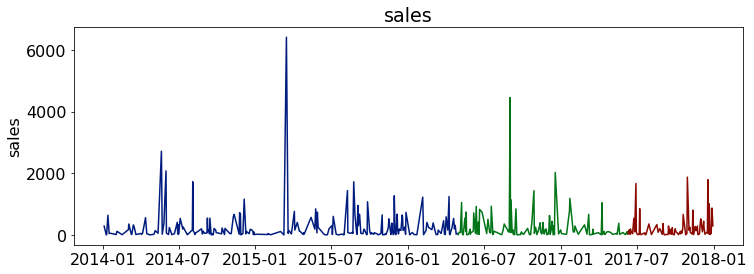

In [21]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [22]:
#From the lesson
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    yhat_df = pd.DataFrame({'sales': [sales],
                           }, index = validate.index)
    return yhat_df

**Simple Average**

In [23]:
sales = round(train['sales'].mean(),2)
yhat_df = make_predictions()

sales -- RMSE: 488


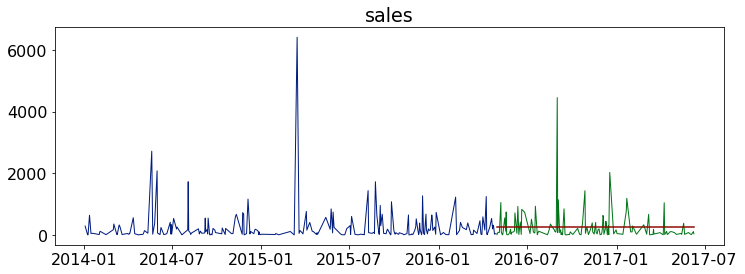

In [24]:
for col in train.columns:
    plot_and_eval(col)

In [25]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [26]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,sales,488.0


**Moving Average**

In [27]:
sales = round(train['sales'].rolling(2).mean().iloc[-1], 2)
yhat_df = make_predictions()

sales -- RMSE: 534


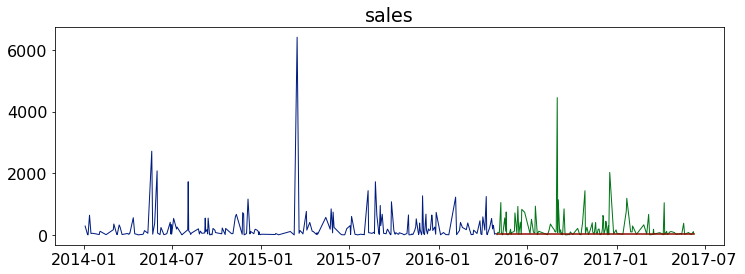

In [28]:
for col in train.columns:
    plot_and_eval(col)

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type='2 month moving average', 
                             target_var = col)

In [30]:
periods = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for p in periods:
    amounts = round(train['sales'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + ' month moving average'
    eval_df = append_eval_df(model_type = model_type, target_var = 'sales')

In [31]:
eval_df

,model_type,target_var,rmse
0,simple_average,sales,488.0
1,2 month moving average,sales,534.0
2,3 month moving average,sales,534.0
3,4 month moving average,sales,534.0
4,5 month moving average,sales,534.0
5,6 month moving average,sales,534.0
6,7 month moving average,sales,534.0
7,8 month moving average,sales,534.0
8,9 month moving average,sales,534.0
9,10 month moving average,sales,534.0


In [32]:
min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

In [33]:
eval_df[((eval_df.rmse == min_rmse_amount))]

,model_type,target_var,rmse
0,simple_average,sales,488.0
